# Build a custom RAG agent

## Overview

In this tutorial we will build a [retrieval](/oss/python/langchain/retrieval) agent using LangGraph.

LangChain offers built-in [agent](/oss/python/langchain/agents) implementations, implemented using [LangGraph](/oss/python/langgraph/overview) primitives. If deeper customization is required, agents can be implemented directly in LangGraph. This guide demonstrates an example implementation of a retrieval agent. [Retrieval](/oss/python/langchain/retrieval) agents are useful when you want an LLM to make a decision about whether to retrieve context from a vectorstore or respond to the user directly.

By the end of the tutorial we will have done the following:

1. Fetch and preprocess documents that will be used for retrieval.
2. Index those documents for semantic search and create a retriever tool for the agent.
3. Build an agentic RAG system that can decide when to use the retriever tool.

## Setup

Verify our API key and download the documents to be indexed for the vector database:

In [41]:
import os
len(os.environ['OPENAI_API_KEY'])

164

## 1. Preprocess documents

1. Fetch documents to use in our RAG system. We will use three of the most recent pages from [Lilian Weng's excellent blog](https://lilianweng.github.io/). We'll start by fetching the content of the pages using `WebBaseLoader` utility:

In [12]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [42]:
docs[0][0].page_content.strip().replace('\n', '')[:1000]

"Reward Hacking in Reinforcement Learning | Lil'LogLil'Log|PostsArchiveSearchTagsFAQ      Reward Hacking in Reinforcement Learning    Date: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng Table of ContentsBackgroundReward Function in RLSpurious CorrelationLet’s Define Reward HackingList of ExamplesReward hacking examples in RL tasksReward hacking examples in LLM tasksReward hacking examples in real lifeWhy does Reward Hacking Exist?Hacking RL EnvironmentHacking RLHF of LLMsHacking the Training ProcessHacking the EvaluatorIn-Context Reward HackingGeneralization of Hacking SkillsPeek into MitigationsRL Algorithm ImprovementDetecting Reward HackingData Analysis of RLHFCitationReferencesReward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is f

### 2. Split the fetched documents into smaller chunks for indexing into our vectorstore:

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [15]:
doc_splits[0].page_content.strip().replace('\n', '')

"Reward Hacking in Reinforcement Learning | Lil'LogLil'Log|PostsArchiveSearchTagsFAQ"

## 2. Create a retriever tool

Now that we have our split documents, we can index them into a vector store that we'll use for semantic search.

1. Use an in-memory vector store and OpenAI embeddings:

In [20]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vectorstore.as_retriever()

In [21]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [22]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Why does Reward Hacking Exist?#\n\nDetecting Reward Hacking#\n\nIn-Context Reward Hacking#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.'

In [23]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("gpt-4o", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [24]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [26]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "How can one prevent reward hacking in RLHF?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_DZg7ySf3YUKMfqb1P1xjw0MG)
 Call ID: call_DZg7ySf3YUKMfqb1P1xjw0MG
  Args:
    query: prevent reward hacking in RLHF


In [27]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("gpt-4o", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [28]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can one prevent reward hacking in RLHF?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "prevent reward hacking in RLHF"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [29]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [30]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [31]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What are the different types of reward hacking that Lilian Weng discusses?


In [32]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [33]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecification, and reward tampering.


In [34]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

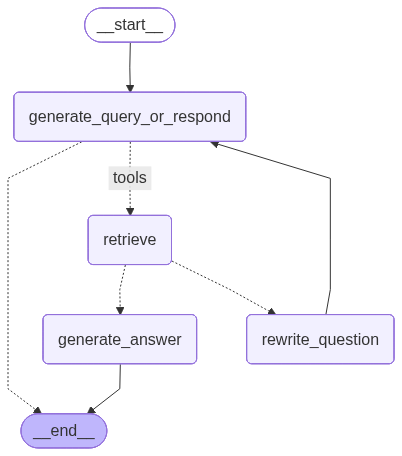

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_s5S2s0cMOfZDqOoC8mLOYLEi)
 Call ID: call_s5S2s0cMOfZDqOoC8mLOYLEi
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Why does Reward Hacking Exist?#

Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.



Update from node generate_answer
================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecificat